In [1]:
import pandas as pd
import numpy as np
import shap
import warnings
import joblib
import sys
import psutil
import GPUtil
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, GroupKFold
from collections import defaultdict
from time import time
from datetime import timedelta
from importlib.metadata import version

# printout of python version
print("="*50, "Python Version", "="*50)
print(f"python version: {sys.version}")
print(f"xgboost:        {version('xgboost')}")
print(f"shap:           {version('shap')}")

# printout of hardware
print("="*50, "Hardware", "="*50)
gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU: {gpu.name}")
print(f"CPU cores: {psutil.cpu_count(logical=False)}")
print(f"RAM: {psutil.virtual_memory().total / 1024 / 1024 / 1024 :.2f} GB")

warnings.filterwarnings('ignore')

================================================== Python Version ==================================================
python version: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
xgboost:        2.1.1
shap:           0.46.0
================================================== Hardware ==================================================
GPU: NVIDIA GeForce RTX 4090
CPU cores: 16
RAM: 63.82 GB


# read data function 

In [2]:
def read_abcd(path, cols, na_values):
    
    df = pd.read_csv(path, sep='\t', index_col='subjectkey', na_values=na_values)
    df = df.drop(df.index[0])
    
    for col in cols:
        df[col] = pd.to_numeric(df[col])
        df = df[cols]

    df = df.reset_index()
    df = df.sort_values(['subjectkey', 'interview_age'])
    df = df.drop_duplicates(subset=['subjectkey'], keep='first')
    df = df.drop(columns=['interview_age'])
    df = df.set_index('subjectkey')
    
    df_show = abcd_ysu02.join(df)
    df_show = df_show.drop(columns=[
        'isip_1d_2',
        'isip_5_2',
        'isip_1b_yn'
    ])
     
    for col in df_show.columns:
        print('{:<30}    n = {:<10}    mean = {:<10.4f}    sum = {:<10.1f}'.\
              format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
    print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))
    
    return df

# y-target variable 

In [3]:
file_abcd_ysu02 = r'D:\gregn\data\ABCD\abcd3\abcd_ysu02.txt'
abcd_ysu02 = pd.read_csv(file_abcd_ysu02, sep='\t', index_col='subjectkey')
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02.index[0])
cols = [
    'interview_age',
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
]

for col in cols:
    abcd_ysu02[col] = pd.to_numeric(abcd_ysu02[col])
    abcd_ysu02 = abcd_ysu02[cols]
    
abcd_ysu02 = abcd_ysu02.reset_index()
abcd_ysu02 = abcd_ysu02.sort_values(['subjectkey', 'interview_age'])
abcd_ysu02 = abcd_ysu02.drop_duplicates(subset=['subjectkey'], keep='first')
abcd_ysu02 = abcd_ysu02.drop(columns=['interview_age'])
abcd_ysu02 = abcd_ysu02.set_index('subjectkey')
    
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_5_2 == 3].index) # drop accidental 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_5_2 == 2].index) # drop furtive 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_1b_yn == 0].index) # drop religious 
abcd_ysu02 = abcd_ysu02.drop(abcd_ysu02[abcd_ysu02.isip_1d_2 > 10].index) # drop older than 10

abcd_ysu02['isip_1d_2'] = abcd_ysu02['isip_1d_2'].fillna(0)

y = abcd_ysu02['isip_1d_2'].values
y = np.where(y>0, 1, y)

unique, counts = np.unique(y, return_counts=True)

print('number of subjects: {:>10}\n\n[0] never sipped: {:>12}\n[1] sipped by age 10:{:>9}'.\
      format(len(y), counts[0], counts[1]))

number of subjects:      10707

[0] never sipped:         9209
[1] sipped by age 10:     1498


# abcd_asrs01

In [4]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_asrs01.txt'

cols = [
    'interview_age',
    'asr_scr_perstr_t',
    'asr_scr_anxdep_t',
    'asr_scr_withdrawn_t',
    'asr_scr_somatic_t',
    'asr_scr_thought_t',
    'asr_scr_attention_t',
    'asr_scr_aggressive_t',
    'asr_scr_rulebreak_t',
    'asr_scr_intrusive_t',
    'asr_scr_internal_t',
    'asr_scr_external_t',
    'asr_scr_totprob_t',
    'asr_scr_depress_t',
    'asr_scr_anxdisord_t',
    'asr_scr_somaticpr_t',
    'asr_scr_avoidant_t',
    'asr_scr_adhd_t',
    'asr_scr_antisocial_t',
    'asr_scr_inattention_t',
    'asr_scr_hyperactive_t'    
]

na_values = [None]
abcd_asrs01 = read_abcd(path, cols, na_values)

asr_scr_perstr_t                  n = 10608         mean = 47.8090       sum = 507158.0  
asr_scr_anxdep_t                  n = 10608         mean = 53.4521       sum = 567020.0  
asr_scr_withdrawn_t               n = 10608         mean = 52.8366       sum = 560491.0  
asr_scr_somatic_t                 n = 10608         mean = 54.7870       sum = 581180.0  
asr_scr_thought_t                 n = 10608         mean = 52.9399       sum = 561586.0  
asr_scr_attention_t               n = 10608         mean = 53.9073       sum = 571849.0  
asr_scr_aggressive_t              n = 10608         mean = 53.3350       sum = 565778.0  
asr_scr_rulebreak_t               n = 10608         mean = 52.5679       sum = 557640.0  
asr_scr_intrusive_t               n = 10608         mean = 51.6443       sum = 547843.0  
asr_scr_internal_t                n = 10608         mean = 48.1090       sum = 510340.0  
asr_scr_external_t                n = 10608         mean = 45.9104       sum = 487018.0  
asr_scr_to

# abcd_rhds01

In [5]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_rhds01.txt'

cols = [
    'interview_age',
    'reshist_addr1_years',
    'reshist_addr1_elevation',
    'reshist_addr1_d1a',
    'reshist_addr1_walkindex',
    'reshist_addr1_grndtot',
    'reshist_addr1_p1tot',
    'reshist_addr1_p1vlnt',
    'reshist_addr1_drugtot',
    'reshist_addr1_drgsale',
    'reshist_addr1_mjsale',
    'reshist_addr1_drgposs',
    'reshist_addr1_dui',
    'reshist_addr1_adi_edu_l',
    'reshist_addr1_adi_edu_h',
    'reshist_addr1_adi_work_c',
    'reshist_addr1_adi_income',
    'reshist_addr1_adi_in_dis',
    'reshist_addr1_adi_home_v',
    'reshist_addr1_adi_rent',
    'reshist_addr1_adi_mortg',
    'reshist_addr1_adi_home_o',
    'reshist_addr1_adi_crowd',
    'reshist_addr1_adi_unemp',
    'reshist_addr1_adi_pov',
    'reshist_addr1_adi_b138',
    'reshist_addr1_adi_sp',
    'reshist_addr1_adi_ncar',
    'reshist_addr1_adi_ntel',
    'reshist_addr1_adi_nplumb',
    'reshist_addr1_adi_wsum',
    'reshist_addr1_adi_perc',
    'reshist_addr1_popdensity',
    'reshist_addr1_no2',
    'reshist_addr1_pm25',
    'reshist_addr1_proxrd',
    'reshist_addr1_pm252016aa',
    'reshist_addr1_leadrisk_poverty',
    'reshist_addr1_leadrisk_housing',
    'reshist_addr1_leadrisk'
]

na_values = [None]
abcd_rhds01 = read_abcd(path, cols, na_values)

reshist_addr1_years               n = 9792          mean = 5.4184        sum = 53057.0   
reshist_addr1_elevation           n = 8233          mean = 332.7681      sum = 2739680.0 
reshist_addr1_d1a                 n = 10072         mean = 3.9956        sum = 40243.4   
reshist_addr1_walkindex           n = 10072         mean = 10.6656       sum = 107423.6  
reshist_addr1_grndtot             n = 10072         mean = 52293.7664    sum = 526702814.9
reshist_addr1_p1tot               n = 10072         mean = 10235.8680    sum = 103095662.5
reshist_addr1_p1vlnt              n = 10072         mean = 3564.0520     sum = 35897131.4
reshist_addr1_drugtot             n = 10072         mean = 7264.1187     sum = 73164203.8
reshist_addr1_drgsale             n = 10072         mean = 1311.3219     sum = 13207634.6
reshist_addr1_mjsale              n = 10072         mean = 462.0419      sum = 4653685.9 
reshist_addr1_drgposs             n = 10072         mean = 5928.4164     sum = 59711010.1
reshist_

# abcd_fes01

In [6]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_fes01.txt'

cols = [
    'interview_age',
    'fes_youth_q1',
    'fes_youth_q2',
    'fes_youth_q3',
    'fes_youth_q4',
    'fes_youth_q5',
    'fes_youth_q6',
    'fes_youth_q7',
    'fes_youth_q8',
    'fes_youth_q9',
]

na_values = [None]
abcd_fes01 = read_abcd(path, cols, na_values)

fes_youth_q1                      n = 10682         mean = 0.2406        sum = 2570.0    
fes_youth_q2                      n = 10683         mean = 0.3312        sum = 3538.0    
fes_youth_q3                      n = 10684         mean = 0.1227        sum = 1311.0    
fes_youth_q4                      n = 10684         mean = 0.3616        sum = 3863.0    
fes_youth_q5                      n = 10684         mean = 0.1912        sum = 2043.0    
fes_youth_q6                      n = 10683         mean = 0.2197        sum = 2347.0    
fes_youth_q7                      n = 10684         mean = 0.0935        sum = 999.0     
fes_youth_q8                      n = 10684         mean = 0.2259        sum = 2413.0    
fes_youth_q9                      n = 10684         mean = 0.2410        sum = 2575.0    

subjects:     10707
features:         9


# fes02

In [7]:
path = r'D:\gregn\data\ABCD\abcd3\fes02.txt'

cols = [
    'interview_age',
    'fam_enviro1_p',
    'fam_enviro2r_p',
    'fam_enviro3_p',
    'fam_enviro4r_p',
    'fam_enviro5_p',
    'fam_enviro6_p',
    'fam_enviro7r_p',
    'fam_enviro8_p',
    'fam_enviro9r_p'
]

na_values = [None]
fes02 = read_abcd(path, cols, na_values)

fam_enviro1_p                     n = 10703         mean = 0.1628        sum = 1742.0    
fam_enviro2r_p                    n = 10702         mean = 0.5010        sum = 5362.0    
fam_enviro3_p                     n = 10703         mean = 0.1276        sum = 1366.0    
fam_enviro4r_p                    n = 10703         mean = 0.5154        sum = 5516.0    
fam_enviro5_p                     n = 10703         mean = 0.3265        sum = 3494.0    
fam_enviro6_p                     n = 10703         mean = 0.1240        sum = 1327.0    
fam_enviro7r_p                    n = 10703         mean = 0.1096        sum = 1173.0    
fam_enviro8_p                     n = 10703         mean = 0.1754        sum = 1877.0    
fam_enviro9r_p                    n = 10697         mean = 0.4840        sum = 5177.0    

subjects:     10707
features:         9


# abcd_ptsd01

In [8]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ptsd01.txt'

cols = [
    'interview_age',
    'ksads_ptsd_raw_754_p',
    'ksads_ptsd_raw_755_p',
    'ksads_ptsd_raw_756_p',
    'ksads_ptsd_raw_757_p',
    'ksads_ptsd_raw_758_p',
    'ksads_ptsd_raw_759_p',
    'ksads_ptsd_raw_760_p', 
    'ksads_ptsd_raw_761_p',
    'ksads_ptsd_raw_762_p', # family
    'ksads_ptsd_raw_763_p', # family
    'ksads_ptsd_raw_764_p',
    'ksads_ptsd_raw_765_p', # family 
    'ksads_ptsd_raw_766_p', # family 
    'ksads_ptsd_raw_767_p', # family 
    'ksads_ptsd_raw_768_p',
    'ksads_ptsd_raw_769_p',
    'ksads_ptsd_raw_770_p'
]

na_values = [None]
abcd_ptsd01 = read_abcd(path, cols, na_values)

ksads_ptsd_raw_754_p              n = 10417         mean = 0.0386        sum = 402.0     
ksads_ptsd_raw_755_p              n = 10417         mean = 0.0418        sum = 435.0     
ksads_ptsd_raw_756_p              n = 10417         mean = 0.0219        sum = 228.0     
ksads_ptsd_raw_757_p              n = 10417         mean = 0.0259        sum = 270.0     
ksads_ptsd_raw_758_p              n = 10417         mean = 0.0033        sum = 34.0      
ksads_ptsd_raw_759_p              n = 10417         mean = 0.0047        sum = 49.0      
ksads_ptsd_raw_760_p              n = 10417         mean = 0.0103        sum = 107.0     
ksads_ptsd_raw_761_p              n = 10417         mean = 0.0037        sum = 39.0      
ksads_ptsd_raw_762_p              n = 10417         mean = 0.0037        sum = 39.0      
ksads_ptsd_raw_763_p              n = 10417         mean = 0.0089        sum = 93.0      
ksads_ptsd_raw_764_p              n = 10417         mean = 0.0069        sum = 72.0      
ksads_ptsd

In [9]:
abcd_ptsd01['ksads_ptsd_home'] = (abcd_ptsd01.ksads_ptsd_raw_762_p
                                 + abcd_ptsd01.ksads_ptsd_raw_763_p
                                 + abcd_ptsd01.ksads_ptsd_raw_765_p
                                 + abcd_ptsd01.ksads_ptsd_raw_766_p
                                 + abcd_ptsd01.ksads_ptsd_raw_767_p)

abcd_ptsd01['ksads_ptsd_outside_home'] = (abcd_ptsd01.ksads_ptsd_raw_754_p
                                         + abcd_ptsd01.ksads_ptsd_raw_755_p
                                         + abcd_ptsd01.ksads_ptsd_raw_756_p
                                         + abcd_ptsd01.ksads_ptsd_raw_757_p
                                         + abcd_ptsd01.ksads_ptsd_raw_758_p
                                         + abcd_ptsd01.ksads_ptsd_raw_759_p
                                         + abcd_ptsd01.ksads_ptsd_raw_760_p
                                         + abcd_ptsd01.ksads_ptsd_raw_761_p
                                         + abcd_ptsd01.ksads_ptsd_raw_764_p
                                         + abcd_ptsd01.ksads_ptsd_raw_768_p
                                         + abcd_ptsd01.ksads_ptsd_raw_769_p
                                         + abcd_ptsd01.ksads_ptsd_raw_770_p)

abcd_ptsd01 = abcd_ptsd01[['ksads_ptsd_home', 'ksads_ptsd_outside_home']]

# abcd_crpf01

In [10]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_crpf01.txt'

cols = [
    'interview_age',
    'su_risk_p_1',
    'su_risk_p_2',
    'su_risk_p_3',
    'su_risk_p_4',
    'su_risk_p_5',
    'su_risk_p_6',
    'su_risk_p_7',
    'su_risk_p_8',
    'su_risk_p_9',
]

na_values = ['777', '999']
abcd_crpf01 = read_abcd(path, cols, na_values)

su_risk_p_1                       n = 10699         mean = 1.0855        sum = 11614.0   
su_risk_p_2                       n = 10699         mean = 0.4566        sum = 4885.0    
su_risk_p_3                       n = 10699         mean = 0.3834        sum = 4102.0    
su_risk_p_4                       n = 10699         mean = 0.3764        sum = 4027.0    
su_risk_p_5                       n = 10699         mean = 0.2999        sum = 3209.0    
su_risk_p_6                       n = 10699         mean = 0.8159        sum = 8729.0    
su_risk_p_7                       n = 4657          mean = 0.8338        sum = 3883.0    
su_risk_p_8                       n = 4662          mean = 0.8539        sum = 3981.0    
su_risk_p_9                       n = 4079          mean = 2.0625        sum = 8413.0    

subjects:     10707
features:         9


# pmq01

In [11]:
path = r'D:\gregn\data\ABCD\abcd3\pmq01.txt'

cols = [
    'interview_age',
    'parent_monitor_q1_y',
    'parent_monitor_q2_y',
    'parent_monitor_q3_y',
    'parent_monitor_q4_y',
    'parent_monitor_q5_y'
]

na_values = [None]
pmq01 = read_abcd(path, cols, na_values)

parent_monitor_q1_y               n = 10687         mean = 4.7216        sum = 50460.0   
parent_monitor_q2_y               n = 10685         mean = 4.5896        sum = 49040.0   
parent_monitor_q3_y               n = 10686         mean = 4.5455        sum = 48573.0   
parent_monitor_q4_y               n = 10687         mean = 3.7554        sum = 40134.0   
parent_monitor_q5_y               n = 10687         mean = 4.3173        sum = 46139.0   

subjects:     10707
features:         5


# crpbi01

In [12]:
path = r'D:\gregn\data\ABCD\abcd3\crpbi01.txt'

cols = [
    'interview_age',
    'crpbi_parent1_y',
    'crpbi_parent2_y',
    'crpbi_parent3_y',
    'crpbi_parent4_y',
    'crpbi_parent5_y',
    'crpbi_caregiver1_y',
]

na_values = [None]
crpbi01 = read_abcd(path, cols, na_values)

crpbi_parent1_y                   n = 10676         mean = 2.7740        sum = 29615.0   
crpbi_parent2_y                   n = 10675         mean = 2.7402        sum = 29252.0   
crpbi_parent3_y                   n = 10674         mean = 2.7924        sum = 29806.0   
crpbi_parent4_y                   n = 10674         mean = 2.9347        sum = 31325.0   
crpbi_parent5_y                   n = 10672         mean = 2.6782        sum = 28582.0   
crpbi_caregiver1_y                n = 10667         mean = 0.9255        sum = 9872.0    

subjects:     10707
features:         6


# pdem02

In [13]:
file_pdem02 = r'D:\gregn\data\ABCD\abcd3\pdem02.txt'
pdem02 = pd.read_csv(file_pdem02, sep='\t', index_col='subjectkey', na_values=['777', '999'])
pdem02 = pdem02.drop(pdem02.index[0])

cols = [
    'interview_age',
    'demo_prim',
    'demo_adopt_agex_v2',
    'demo_sex_v2',
    'demo_gender_id_v2',
    'demo_prnt_age_v2',
    'demo_prnt_gender_id_v2',
    'demo_prnt_marital_v2',
    'demo_prnt_ed_v2',
    'demo_prnt_empl_v2',
    'demo_prnt_empl_time',
    'demo_prnt_income_v2',
    'demo_prnt_prtnr_v2',
    'demo_comb_income_v2',
    'demo_fam_exp1_v2',
    'demo_fam_exp2_v2',
    'demo_fam_exp3_v2',
    'demo_fam_exp4_v2',
    'demo_fam_exp5_v2',
    'demo_fam_exp6_v2',
    'demo_fam_exp7_v2'
]

for col in cols:
    pdem02[col] = pd.to_numeric(pdem02[col])
    pdem02 = pdem02[cols]
    
pdem02 = pd.get_dummies(pdem02, columns=[
    'demo_prim',
    'demo_sex_v2',
    'demo_gender_id_v2',
    'demo_prnt_gender_id_v2',
    'demo_prnt_marital_v2',
    'demo_prnt_empl_v2',
], dtype=float)

pdem02 = pdem02.rename(columns={
    'demo_prim_1': 'demo_prim_biological_mother',
    'demo_prim_2': 'demo_prim_biological_father',
    'demo_prim_3': 'demo_prim_adoptive_parent',
    'demo_prim_4': 'demo_prim_custodial_parent',
    'demo_prim_5': 'demo_prim_other',
    'demo_sex_v2_1': 'demo_sex_v2_male',
    'demo_sex_v2_2': 'demo_sex_v2_female',
    'demo_sex_v2_3': 'demo_sex_v2_intersex-male', 
    'demo_gender_id_v2_1.0': 'demo_gender_id_v2_male',
    'demo_gender_id_v2_2.0': 'demo_gender_id_v2_female',
    'demo_gender_id_v2_3.0': 'demo_gender_id_v2_trans_male',
    'demo_gender_id_v2_4.0': 'demo_gender_id_v2_trans_female',
    'demo_gender_id_v2_5.0': 'demo_gender_id_v2_gender_queer',
    'demo_gender_id_v2_6.0': 'demo_gender_id_v2_different',
    'demo_prnt_gender_id_v2_1.0': 'demo_prnt_gender_id_v2_male',
    'demo_prnt_gender_id_v2_2.0': 'demo_prnt_gender_id_v2_female',
    'demo_prnt_gender_id_v2_3.0': 'demo_prnt_gender_id_v2_trans_male',
    'demo_prnt_gender_id_v2_4.0': 'demo_prnt_gender_id_v2_trans_female',
    'demo_prnt_gender_id_v2_5.0': 'demo_prnt_gender_id_v2_gender_queer',
    'demo_prnt_gender_id_v2_6.0': 'demo_prnt_gender_id_v2_different',
    'demo_prnt_marital_v2_1.0': 'demo_prnt_marital_v2_married',
    'demo_prnt_marital_v2_2.0': 'demo_prnt_marital_v2_widowed',
    'demo_prnt_marital_v2_3.0': 'demo_prnt_marital_v2_divorced',
    'demo_prnt_marital_v2_4.0': 'demo_prnt_marital_v2_separated',
    'demo_prnt_marital_v2_5.0': 'demo_prnt_marital_v2_never_married',
    'demo_prnt_marital_v2_6.0': 'demo_prnt_marital_v2_living_with_partner',
    'demo_prnt_empl_v2_1.0': 'demo_prnt_empl_v2_working_now',
    'demo_prnt_empl_v2_2.0': 'demo_prnt_empl_v2_temporarily_laid_off',
    'demo_prnt_empl_v2_3.0': 'demo_prnt_empl_v2_looking_for_work',
    'demo_prnt_empl_v2_4.0': 'demo_prnt_empl_v2_retired',
    'demo_prnt_empl_v2_5.0': 'demo_prnt_empl_v2_disabled',
    'demo_prnt_empl_v2_6.0': 'demo_prnt_empl_v2_stay_at_home_parent',
    'demo_prnt_empl_v2_7.0': 'demo_prnt_empl_v2_student',
    'demo_prnt_empl_v2_8.0': 'demo_prnt_empl_v2_other',
    'demo_prnt_empl_v2_9.0': 'demo_prnt_empl_v2_sick_leave',
    'demo_prnt_empl_v2_10.0': 'demo_prnt_empl_v2_maternity_leave',
    'demo_prnt_empl_v2_11.0': 'demo_prnt_empl_v2_unemployed_not_looking'   
})


pdem02['demo_gender_id_v2_non-binary'] = (pdem02.demo_gender_id_v2_trans_male
                                         + pdem02.demo_gender_id_v2_trans_female
                                         + pdem02.demo_gender_id_v2_gender_queer
                                         + pdem02.demo_gender_id_v2_different)

pdem02['demo_prnt_gender_id_v2_non-binary'] = (pdem02.demo_prnt_gender_id_v2_trans_male
                                              + pdem02.demo_prnt_gender_id_v2_trans_female
                                              + pdem02.demo_prnt_gender_id_v2_gender_queer
                                              + pdem02.demo_prnt_gender_id_v2_different)


pdem02 = pdem02.drop(columns=[
    'demo_gender_id_v2_trans_male',
    'demo_gender_id_v2_trans_female',
    'demo_gender_id_v2_gender_queer',
    'demo_gender_id_v2_different',
    'demo_prnt_gender_id_v2_trans_male',
    'demo_prnt_gender_id_v2_trans_female',
    'demo_prnt_gender_id_v2_gender_queer',
    'demo_prnt_gender_id_v2_different',
    'demo_sex_v2_intersex-male'
])

pdem02 = pdem02.reset_index()
pdem02 = pdem02.sort_values(['subjectkey', 'interview_age'])
pdem02 = pdem02.drop_duplicates(subset=['subjectkey'], keep='first')
pdem02 = pdem02.drop(columns=['interview_age'])
pdem02 = pdem02.set_index('subjectkey')

df_show = abcd_ysu02.join(pdem02)
df_show = df_show.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
])

for col in df_show.columns:
    print('{:<40}    n = {:<10}    mean = {:<10.4f}    sum = {:<10}'.\
          format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))

demo_adopt_agex_v2                          n = 252           mean = 2.2289        sum = 561.68    
demo_prnt_age_v2                            n = 10620         mean = 39.8566       sum = 423277.1  
demo_prnt_ed_v2                             n = 10692         mean = 16.5397       sum = 176843.0  
demo_prnt_empl_time                         n = 7314          mean = 1.2740        sum = 9318.0    
demo_prnt_income_v2                         n = 9699          mean = 4.8610        sum = 47147.0   
demo_prnt_prtnr_v2                          n = 10594         mean = 1.1937        sum = 12646.0   
demo_comb_income_v2                         n = 9772          mean = 7.1823        sum = 70185.0   
demo_fam_exp1_v2                            n = 10632         mean = 0.0837        sum = 890.0     
demo_fam_exp2_v2                            n = 10661         mean = 0.0623        sum = 664.0     
demo_fam_exp3_v2                            n = 10649         mean = 0.1097        sum = 1168.0    


# abcd_meim01

In [14]:
file_abcd_meim01 = r'D:\gregn\data\ABCD\abcd3\abcd_meim01.txt'
abcd_meim01 = pd.read_csv(file_abcd_meim01, sep='\t', index_col='subjectkey', na_values=['777', '999'])
abcd_meim01 = abcd_meim01.drop(abcd_meim01.index[0])

cols = [
    'interview_age',
    'meim_ethnic_id_p',
]

for col in cols:
    abcd_meim01[col] = pd.to_numeric(abcd_meim01[col])
    abcd_meim01 = abcd_meim01[cols]

abcd_meim01 = pd.get_dummies(abcd_meim01, columns=['meim_ethnic_id_p'], dtype=float)

abcd_meim01 = abcd_meim01.rename(columns={
    'meim_ethnic_id_p_0.0': 'meim_ethnic_id_p_none',
    'meim_ethnic_id_p_1.0': 'meim_ethnic_id_p_white/caucasian',
    'meim_ethnic_id_p_2.0': 'meim_ethnic_id_p_western_european',
    'meim_ethnic_id_p_3.0': 'meim_ethnic_id_p_eastern_european',
    'meim_ethnic_id_p_4.0': 'meim_ethnic_id_p_hispanic/latino',
    'meim_ethnic_id_p_5.0': 'meim_ethnic_id_p_black/african_american',
    'meim_ethnic_id_p_6.0': 'meim_ethnic_id_p_afro-carribean/indo-carribbean/west_indian',
    'meim_ethnic_id_p_7.0': 'meim_ethnic_id_p_east_asian',
    'meim_ethnic_id_p_8.0': 'meim_ethnic_id_p_south_asian',
    'meim_ethnic_id_p_9.0': 'meim_ethnic_id_p_southeast_asian',
    'meim_ethnic_id_p_10.0': 'meim_ethnic_id_p_american_indian/alaska_native',
    'meim_ethnic_id_p_11.0': 'meim_ethnic_id_p_middle_eastern/north_african',
    'meim_ethnic_id_p_12.0': 'meim_ethnic_id_p_native_hawaiian_or_pacific_islander',
    'meim_ethnic_id_p_13.0': 'meim_ethnic_id_p_mixed',
    'meim_ethnic_id_p_14.0': 'meim_ethnic_id_p_other'
})

abcd_meim01 = abcd_meim01.reset_index()
abcd_meim01 = abcd_meim01.sort_values(['subjectkey', 'interview_age'])
abcd_meim01 = abcd_meim01.drop_duplicates(subset=['subjectkey'], keep='first')
abcd_meim01 = abcd_meim01.drop(columns=['interview_age'])
abcd_meim01 = abcd_meim01.set_index('subjectkey')

df_show = abcd_ysu02.join(abcd_meim01)
df_show = df_show.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
])

for col in df_show.columns:
    print('{:<60}    n = {:<10}    mean = {:<10.4f}    sum = {:<10}'.\
          format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))

meim_ethnic_id_p_none                                           n = 10707         mean = 0.0663        sum = 710.0     
meim_ethnic_id_p_white/caucasian                                n = 10707         mean = 0.5314        sum = 5690.0    
meim_ethnic_id_p_western_european                               n = 10707         mean = 0.0128        sum = 137.0     
meim_ethnic_id_p_eastern_european                               n = 10707         mean = 0.0040        sum = 43.0      
meim_ethnic_id_p_hispanic/latino                                n = 10707         mean = 0.1455        sum = 1558.0    
meim_ethnic_id_p_black/african_american                         n = 10707         mean = 0.1454        sum = 1557.0    
meim_ethnic_id_p_afro-carribean/indo-carribbean/west_indian     n = 10707         mean = 0.0028        sum = 30.0      
meim_ethnic_id_p_east_asian                                     n = 10707         mean = 0.0182        sum = 195.0     
meim_ethnic_id_p_south_asian            

# abcd_sscep01

In [15]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_sscep01.txt'

cols = [
    'interview_age',
    'meim_p_ss_exp',
    'meim_p_ss_com',
    'meim_p_ss_total',
    'via_p_ss_hc',
    'via_p_ss_amer',
    'nsc_p_ss_mean_3_items',
    'fes_p_ss_fc_pr',
    'macv_p_ss_fs',
    'macv_p_ss_fo',
    'macv_p_ss_isr',
    'macv_p_ss_fr',
    'macv_p_ss_r',
    'psb_p_ss_mean',
    
]

na_values = [None]
abcd_sscep01 = read_abcd(path, cols, na_values)

meim_p_ss_exp                     n = 10076         mean = 3.1686        sum = 31926.7   
meim_p_ss_com                     n = 10076         mean = 3.5041        sum = 35307.7   
meim_p_ss_total                   n = 10076         mean = 3.3364        sum = 33617.2   
via_p_ss_hc                       n = 7061          mean = 6.3347        sum = 44729.5   
via_p_ss_amer                     n = 7061          mean = 6.8017        sum = 48026.5   
nsc_p_ss_mean_3_items             n = 10700         mean = 3.8842        sum = 41561.2   
fes_p_ss_fc_pr                    n = 10703         mean = 2.5260        sum = 27035.9   
macv_p_ss_fs                      n = 10701         mean = 4.1643        sum = 44562.1   
macv_p_ss_fo                      n = 10701         mean = 3.6362        sum = 38910.8   
macv_p_ss_isr                     n = 10701         mean = 3.5607        sum = 38103.0   
macv_p_ss_fr                      n = 10701         mean = 3.3941        sum = 36319.8   
macv_p_ss_

# yacc01

In [16]:
path = r'D:\gregn\data\ABCD\abcd3\yacc01.txt'

cols = [
    'interview_age',
    'accult_q1_y',
    'accult_q2_y',
    'accult_q4_y',
    'accult_q5_y'
]

na_values = ['777', '999']
yacc01 = read_abcd(path, cols, na_values)

accult_q1_y                       n = 10688         mean = 3.7084        sum = 39635.0   
accult_q2_y                       n = 10636         mean = 0.3717        sum = 3953.0    
accult_q4_y                       n = 3953          mean = 4.4935        sum = 17763.0   
accult_q5_y                       n = 3953          mean = 3.7797        sum = 14941.0   

subjects:     10707
features:         4


# pacc01

In [17]:
path = r'D:\gregn\data\ABCD\abcd3\pacc01.txt'

cols = [
    'interview_age',
    'accult_q1_p',
    'accult_q2_p',
    'accult_q4_p',
    'accult_q5_p'
]

na_values = ['777', '999']
pacc01 = read_abcd(path, cols, na_values)

accult_q1_p                       n = 10635         mean = 3.8062        sum = 40479.0   
accult_q2_p                       n = 10702         mean = 0.3215        sum = 3441.0    
accult_q4_p                       n = 3422          mean = 4.0190        sum = 13753.0   
accult_q5_p                       n = 3427          mean = 3.7318        sum = 12789.0   

subjects:     10707
features:         4


# fhxp102

In [18]:
path = r'D:\gregn\data\ABCD\abcd3\fhxp102.txt'

cols = [
    'interview_age',
    'famhx_4d_p___0',
    'famhx_4d_p___1',
    'famhx_4d_p___2',
    'famhx_4d_p___3',
    'famhx_4d_p___7',
    'famhx_4d_p___4',
    'famhx_4d_p___5',
    'famhx_4d_p___6',
    'famhx4a_p___0',
    'famhx4a_p___1',
    'famhx4a_p___2',
    'famhx4a_p___3',
    'famhx4a_p___7',
    'famhx4a_p___4',
    'famhx4a_p___5',
    'famhx4a_p___6',
    'fam_history_q5a_drugs___0',
    'fam_history_q5a_drugs___1',
    'fam_history_q5a_drugs___2',
    'fam_history_q5a_drugs___3',
    'fam_history_q5a_drugs___7',
    'fam_history_q5a_drugs___4',
    'fam_history_q5a_drugs___5',
    'fam_history_q5a_drugs___6',
    'fam_history_q5d_drugs___0',
    'fam_history_q5d_drugs___1',
    'fam_history_q5d_drugs___2',
    'fam_history_q5d_drugs___3',
    'fam_history_q5d_drugs___7',
    'fam_history_q5d_drugs___4',
    'fam_history_q5d_drugs___5',
    'fam_history_q5d_drugs___6',
    'fam_history_q6a_depression',
    'fam_history_q6d_depression',
    'famhx_4d_p___999',
    'famhx4a_p___999',
    'fam_history_q5a_drugs___999',
    'fam_history_q5d_drugs___999',
    'famhx_4d_p___888'
    
]

na_values = ['999']
fhxp102 = read_abcd(path, cols, na_values)

famhx_4d_p___0                    n = 10707         mean = 0.3826        sum = 4097.0    
famhx_4d_p___1                    n = 10707         mean = 0.0115        sum = 123.0     
famhx_4d_p___2                    n = 10707         mean = 0.0105        sum = 112.0     
famhx_4d_p___3                    n = 10707         mean = 0.0228        sum = 244.0     
famhx_4d_p___7                    n = 10707         mean = 0.0106        sum = 113.0     
famhx_4d_p___4                    n = 10707         mean = 0.0163        sum = 175.0     
famhx_4d_p___5                    n = 10707         mean = 0.0069        sum = 74.0      
famhx_4d_p___6                    n = 10707         mean = 0.0181        sum = 194.0     
famhx4a_p___0                     n = 10707         mean = 0.2971        sum = 3181.0    
famhx4a_p___1                     n = 10707         mean = 0.0571        sum = 611.0     
famhx4a_p___2                     n = 10707         mean = 0.0420        sum = 450.0     
famhx4a_p_

# fhxp201

In [19]:
path = r'D:\gregn\data\ABCD\abcd3\fhxp201.txt'

cols = [
    'interview_age',
    'fam_history_q7a_mania',
    'fam_history_q7d_mania',
    'fam_history_q8a_visions',
    'fam_history_q8d_visions',
    'fam_history_q9a_trouble',
    'fam_history_q9d_trouble',
    'fam_history_q10a_nerves',
    'fam_history_q10d_nerves',
    'fam_history_q11a_professional',
    'fam_history_q11d_professional',
    'fam_history_q12a_hospitalized',
    'fam_history_q12d_hospitalized',
    'fam_history_q13a_suicide',
    'fam_history_q13d_suicide'
]

na_values = ['999']
fhxp201 = read_abcd(path, cols, na_values)

fam_history_q7a_mania             n = 1342          mean = 0.2012        sum = 270.0     
fam_history_q7d_mania             n = 1402          mean = 0.1840        sum = 258.0     
fam_history_q8a_visions           n = 1042          mean = 0.1334        sum = 139.0     
fam_history_q8d_visions           n = 1078          mean = 0.0863        sum = 93.0      
fam_history_q9a_trouble           n = 3093          mean = 0.3993        sum = 1235.0    
fam_history_q9d_trouble           n = 3154          mean = 0.1078        sum = 340.0     
fam_history_q10a_nerves           n = 2683          mean = 0.1837        sum = 493.0     
fam_history_q10d_nerves           n = 2796          mean = 0.3197        sum = 894.0     
fam_history_q11a_professional     n = 6162          mean = 0.3457        sum = 2130.0    
fam_history_q11d_professional     n = 6389          mean = 0.5112        sum = 3266.0    
fam_history_q12a_hospitalized     n = 3030          mean = 0.1515        sum = 459.0     
fam_histor

# prq01

In [20]:
file_prq01 = r'D:\gregn\data\ABCD\abcd3\prq01.txt'
prq01 = pd.read_csv(file_prq01, sep='\t', index_col='subjectkey')
prq01 = prq01.drop(prq01.index[0])

cols = [
    'interview_age',
    'parent_rules_q1',
    'parent_rules_q1a',
    'parent_rules_q2',
    'parent_rules_q3',
    'parent_rules_q4',
    'parent_rules_q5',
    'parent_rules_q6',
    'parent_rules_q7',
    'parent_rules_q8',
    'parent_rules_q9',
]

for col in cols:
    prq01[col] = pd.to_numeric(prq01[col])
    prq01 = prq01[cols]
    
prq01 = pd.get_dummies(prq01, columns=[
    'parent_rules_q1',
    'parent_rules_q1a',
    'parent_rules_q3',
    'parent_rules_q4',
    'parent_rules_q5',
    'parent_rules_q6',
    'parent_rules_q7',
    'parent_rules_q8',
    'parent_rules_q9',
], dtype=float)

prq01['parent_rules_q1_allowed'] = (prq01['parent_rules_q1_2.0']
                                   + prq01['parent_rules_q1_3.0']
                                   + prq01['parent_rules_q1_4.0'])

prq01 = prq01.drop(columns=[
    'parent_rules_q1_2.0',
    'parent_rules_q1_3.0',
    'parent_rules_q1_4.0',
    'parent_rules_q4_2.0',
    'parent_rules_q4_3.0',
    'parent_rules_q4_4.0',
    'parent_rules_q4_5.0',
    'parent_rules_q4_6.0',
    'parent_rules_q7_2.0',
    'parent_rules_q7_3.0',
    'parent_rules_q7_4.0',
    'parent_rules_q7_5.0',
    'parent_rules_q7_6.0'
])

prq01 = prq01.reset_index()
prq01 = prq01.sort_values(['subjectkey', 'interview_age'])
prq01 = prq01.drop_duplicates(subset=['subjectkey'], keep='first')
prq01 = prq01.drop(columns=['interview_age'])
prq01 = prq01.set_index('subjectkey')

df_show = abcd_ysu02.join(prq01)
df_show = df_show.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
])

for col in df_show.columns:
    print('{:<40}    n = {:<10}    mean = {:<10.4f}    sum = {:<10}'.\
          format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))

parent_rules_q2                             n = 8269          mean = 0.6143        sum = 5080.0    
parent_rules_q1_1.0                         n = 10707         mean = 0.7576        sum = 8112.0    
parent_rules_q1_5.0                         n = 10707         mean = 0.0032        sum = 34.0      
parent_rules_q1_6.0                         n = 10707         mean = 0.2235        sum = 2393.0    
parent_rules_q1a_1.0                        n = 10707         mean = 0.0240        sum = 257.0     
parent_rules_q1a_2.0                        n = 10707         mean = 0.3229        sum = 3457.0    
parent_rules_q1a_3.0                        n = 10707         mean = 0.1797        sum = 1924.0    
parent_rules_q3_0.0                         n = 10707         mean = 0.0040        sum = 43.0      
parent_rules_q3_1.0                         n = 10707         mean = 0.1212        sum = 1298.0    
parent_rules_q3_4.0                         n = 10707         mean = 0.3492        sum = 3739.0    


# dhx01

In [21]:
path = r'D:\gregn\data\ABCD\abcd3\dhx01.txt'

cols = [ 
    'interview_age',
    'devhx_3_p',
    'devhx_4_p',
    'devhx_6_p',
    'devhx_7_p',
    'devhx_10',
    'devhx_10a3_p',
    'devhx_10b3_p',
    'devhx_10c3_p',
    'devhx_10d3_p',
    'devhx_10e3_p',
    'devhx_10f3_p',
    'devhx_10g3_p',
    'devhx_10h3_p',
    'devhx_10i3_p',
    'devhx_10j3_p',
    'devhx_10k3_p',
    'devhx_10l3_p',
    'devhx_10m3_p',
    'devhx_11_p', 
    'devhx_13_3_p',
    'devhx_14a3_p',
    'devhx_14b3_p',
    'devhx_14c3_p',
    'devhx_14d3_p',
    'devhx_14e3_p',
    'devhx_14f3_p',
    'devhx_14g3_p',
    'devhx_14h3_p',
    'devhx_15',
    'devhx_16_p',
    'devhx_17_p',
    'devhx_18_p',
    'devhx_19a_p',
    'devhx_19b_p',
    'devhx_19c_p',
    'devhx_19d_p',
    'devhx_20_p',
    'devhx_21_p',
    'devhx_22_3_p',
    'devhx_23b_p'
]

na_values = ['-1', '999']
dhx01 = read_abcd(path, cols, na_values)

devhx_3_p                         n = 10460         mean = 29.2909       sum = 306383.0  
devhx_4_p                         n = 10111         mean = 31.7840       sum = 321368.0  
devhx_6_p                         n = 10462         mean = 0.6082        sum = 6363.0    
devhx_7_p                         n = 9428          mean = 6.9374        sum = 65406.0   
devhx_10                          n = 10271         mean = 0.9538        sum = 9796.0    
devhx_10a3_p                      n = 10352         mean = 0.1445        sum = 1496.0    
devhx_10b3_p                      n = 10409         mean = 0.0452        sum = 470.0     
devhx_10c3_p                      n = 10354         mean = 0.0778        sum = 806.0     
devhx_10d3_p                      n = 10401         mean = 0.0112        sum = 116.0     
devhx_10e3_p                      n = 10336         mean = 0.0050        sum = 52.0      
devhx_10f3_p                      n = 10420         mean = 0.0015        sum = 16.0      
devhx_10g3

# birth weight

In [22]:
path = r'D:\gregn\data\ABCD\source\ABCD072120NonImaging\dhx01.txt'

cols = [
    'interview_age',
    'birth_weight_lbs',
    'birth_weight_oz'
]

na_values = [None]
birth_weight = read_abcd(path, cols, na_values)

birth_weight_lbs                  n = 10220         mean = 6.5868        sum = 67317.0   
birth_weight_oz                   n = 9543          mean = 7.1381        sum = 68119.0   

subjects:     10707
features:         2


In [23]:
birth_weight['birth_weight'] = (birth_weight.birth_weight_lbs
                               + (birth_weight.birth_weight_oz * 0.0625))

birth_weight = birth_weight.drop(columns=['birth_weight_lbs', 'birth_weight_oz'])

# abcd_devhxss01

In [24]:
file_abcd_devhxss01 = r'D:\gregn\data\ABCD\abcd3\abcd_devhxss01.txt'

abcd_devhxss01 = pd.read_csv(file_abcd_devhxss01, sep='\t', index_col='subjectkey', na_values=999)
abcd_devhxss01 = abcd_devhxss01.drop(abcd_devhxss01.index[0])

cols = [
    'interview_age',
    'devhx_ss_8_cigs_per_day_p',
    'devhx_ss_8_alcohol_max_p',
    'devhx_ss_8_alcohol_avg_p',
    'devhx_ss_8_alcohol_effects_p',
    'devhx_ss_8_marijuana_amt_p',
    'devhx_ss_8_coc_crack_amt_p',
    'devhx_ss_8_her_morph_amt_p',
    'devhx_ss_8_oxycont_amt_p',
    'devhx_ss_9_cigs_per_day_p',
    'devhx_ss_9_alcohol_max_p',
    'devhx_ss_9_alcohol_avg_p',
    'devhx_ss_9_alcohol_effects_p',
    'devhx_ss_9_marijuana_amt_p',
    'devhx_ss_9_coc_crack_amt_p',
    'devhx_ss_9_her_morph_amt_p',
    'devhx_ss_9_oxycont_amt_p',
    'devhx_ss_12_p'
]

for col in cols:
    abcd_devhxss01[col] = pd.to_numeric(abcd_devhxss01[col])
    abcd_devhxss01 = abcd_devhxss01[cols]
    
abcd_devhxss01 = abcd_devhxss01.reset_index()
abcd_devhxss01 = abcd_devhxss01.sort_values(['subjectkey', 'interview_age'])
abcd_devhxss01 = abcd_devhxss01.drop_duplicates(subset=['subjectkey'], keep='first')
abcd_devhxss01 = abcd_devhxss01.drop(columns=['interview_age'])
abcd_devhxss01 = abcd_devhxss01.set_index('subjectkey')

abcd_devhxss01['devhx_ss_coc_crack_amt_p'] = (abcd_devhxss01.devhx_ss_8_coc_crack_amt_p
                                              + abcd_devhxss01.devhx_ss_9_coc_crack_amt_p) / 2

abcd_devhxss01['devhx_ss_her_morph_oxycont_amt_p'] = (abcd_devhxss01.devhx_ss_8_her_morph_amt_p
                                                      + abcd_devhxss01.devhx_ss_9_her_morph_amt_p
                                                      + abcd_devhxss01.devhx_ss_8_oxycont_amt_p
                                                      + abcd_devhxss01.devhx_ss_9_oxycont_amt_p) / 4


abcd_devhxss01 = abcd_devhxss01.drop(columns=[
    'devhx_ss_8_coc_crack_amt_p',
    'devhx_ss_9_coc_crack_amt_p',
    'devhx_ss_8_her_morph_amt_p',
    'devhx_ss_9_her_morph_amt_p',
    'devhx_ss_8_oxycont_amt_p',
    'devhx_ss_9_oxycont_amt_p'
])

df_show = abcd_ysu02.join(abcd_devhxss01)
df_show = df_show.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
])

for col in df_show.columns:
    print('{:<40}    n = {:<10}    mean = {:<10.4f}    sum = {:<10}'.\
          format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))

devhx_ss_8_cigs_per_day_p                   n = 10289         mean = 1.0220        sum = 10515.5   
devhx_ss_8_alcohol_max_p                    n = 9792          mean = 0.5376        sum = 5264.5    
devhx_ss_8_alcohol_avg_p                    n = 9761          mean = 0.8746        sum = 8536.529999999999
devhx_ss_8_alcohol_effects_p                n = 9637          mean = 0.4397        sum = 4237.75   
devhx_ss_8_marijuana_amt_p                  n = 10212         mean = 0.0883        sum = 902.0799999999999
devhx_ss_9_cigs_per_day_p                   n = 10360         mean = 0.3194        sum = 3308.5    
devhx_ss_9_alcohol_max_p                    n = 10382         mean = 0.0287        sum = 298.0     
devhx_ss_9_alcohol_avg_p                    n = 10377         mean = 0.0446        sum = 462.66999999999996
devhx_ss_9_alcohol_effects_p                n = 10347         mean = 0.0326        sum = 337.25    
devhx_ss_9_marijuana_amt_p                  n = 10364         mean = 0.0250   

# acspsw03

In [25]:
path = r'D:\gregn\data\ABCD\abcd3\acspsw03.txt'

cols = [
    'interview_age',
    'rel_family_id',
    'acs_raked_propensity_score'
]

na_values = [None]
acspsw03 = read_abcd(path, cols, na_values)

rel_family_id                     n = 10707         mean = 5921.1416     sum = 63397663.0
acs_raked_propensity_score        n = 10707         mean = 690.4637      sum = 7392794.6 

subjects:     10707
features:         2


# abcd_saiq02

In [26]:
file_abcd_saiq02 = r'D:\gregn\data\ABCD\abcd3\abcd_saiq02.txt'
abcd_saiq02 = pd.read_csv(file_abcd_saiq02, sep='\t', index_col='subjectkey')
abcd_saiq02 = abcd_saiq02.drop(abcd_saiq02.index[0])

cols = [
    'interview_age',
    'sai_p_activities___0',
    'sai_p_activities___1',
    'sai_p_activities___2',
    'sai_p_activities___3',
    'sai_p_activities___4',
    'sai_p_activities___5',
    'sai_p_activities___6',
    'sai_p_activities___7',
    'sai_p_activities___8',
    'sai_p_activities___9',
    'sai_p_activities___10',
    'sai_p_activities___11',
    'sai_p_activities___12',
    'sai_p_activities___13',
    'sai_p_activities___14',
    'sai_p_activities___15',
    'sai_p_activities___16',
    'sai_p_activities___17',
    'sai_p_activities___18',
    'sai_p_activities___19',
    'sai_p_activities___20',
    'sai_p_activities___21',
    'sai_p_activities___22',
    'sai_p_activities___23',
    'sai_p_activities___24',
    'sai_p_activities___25',
    'sai_p_activities___26',
    'sai_p_activities___27',
    'sai_p_activities___28',
    'sai_p_activities___29'
]

for col in cols:
    abcd_saiq02[col] = pd.to_numeric(abcd_saiq02[col])
    abcd_saiq02 = abcd_saiq02[cols]
    
    
abcd_saiq02 = abcd_saiq02.reset_index()
abcd_saiq02 = abcd_saiq02.sort_values(['subjectkey', 'interview_age'])
abcd_saiq02 = abcd_saiq02.drop_duplicates(subset=['subjectkey'], keep='first')
abcd_saiq02 = abcd_saiq02.drop(columns=['interview_age'])
abcd_saiq02 = abcd_saiq02.set_index('subjectkey')

abcd_saiq02['sai_involvement_sum'] = abcd_saiq02.sum(axis=1)
abcd_saiq02 = abcd_saiq02.iloc[:, -1]

df = abcd_saiq02
print('sai_involvement_sum     n = {:<10}    mean = {:<10.4f}'.\
      format( abcd_saiq02.notnull().sum(), abcd_saiq02.mean()))

sai_involvement_sum     n = 11878         mean = 3.6637    


# abcd_ssmty01

In [27]:
path = r'D:\gregn\data\ABCD\abcd3\abcd_ssmty01.txt'

cols = [
    'interview_age',
    'stq_y_ss_weekday',
    'stq_y_ss_weekend'
]

na_values = [None]
abcd_ssmty01 = read_abcd(path, cols, na_values)

stq_y_ss_weekday                  n = 10685         mean = 3.4637        sum = 37009.2   
stq_y_ss_weekend                  n = 10684         mean = 4.6037        sum = 49185.5   

subjects:     10707
features:         2


# abcd_lt01

In [28]:
file_abcd_lt01 = r'D:\gregn\data\ABCD\abcd3\abcd_lt01.txt'

abcd_lt01 = pd.read_csv(file_abcd_lt01, sep='\t', index_col='subjectkey')
abcd_lt01 = abcd_lt01.drop(abcd_lt01.index[0])

cols = [
    'interview_age',
    'site_id_l'
]

abcd_lt01 = pd.get_dummies(abcd_lt01, columns=['site_id_l'], dtype=float)

abcd_lt01 = abcd_lt01.reset_index()
abcd_lt01 = abcd_lt01.sort_values(['subjectkey', 'interview_age'])
abcd_lt01 = abcd_lt01.drop_duplicates(subset=['subjectkey'], keep='first')
abcd_lt01 = abcd_lt01.drop(columns=['interview_age'])
abcd_lt01 = abcd_lt01.set_index('subjectkey')

abcd_lt01 = abcd_lt01.iloc[:, 8:]

df_show = abcd_ysu02.join(abcd_lt01)
df_show = df_show.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn'
])

for col in df_show.columns:
    print('{:<40}    n = {:<10}    mean = {:<10.4f}    sum = {:<10}'.\
          format(col,  df_show[col].notnull().sum(), df_show[col].mean(), df_show[col].sum()))    
print('\nsubjects:{:>10}\nfeatures:{:>10}'.format(df_show.shape[0], df_show.shape[1]))

site_id_l_site01                            n = 10707         mean = 0.0345        sum = 369.0     
site_id_l_site02                            n = 10707         mean = 0.0468        sum = 501.0     
site_id_l_site03                            n = 10707         mean = 0.0531        sum = 569.0     
site_id_l_site04                            n = 10707         mean = 0.0616        sum = 660.0     
site_id_l_site05                            n = 10707         mean = 0.0311        sum = 333.0     
site_id_l_site06                            n = 10707         mean = 0.0497        sum = 532.0     
site_id_l_site07                            n = 10707         mean = 0.0280        sum = 300.0     
site_id_l_site08                            n = 10707         mean = 0.0289        sum = 309.0     
site_id_l_site09                            n = 10707         mean = 0.0357        sum = 382.0     
site_id_l_site10                            n = 10707         mean = 0.0616        sum = 660.0     


# join dataframes

In [29]:
dfs = [
    abcd_ysu02,
    abcd_asrs01,
    abcd_rhds01,
    abcd_fes01,
    fes02,
    abcd_ptsd01,
    abcd_crpf01,
    pmq01,
    crpbi01,
    pdem02,
    abcd_meim01,
    abcd_sscep01,
    yacc01,
    pacc01,
    fhxp102,
    fhxp201,
    prq01,
    dhx01, 
    birth_weight,
    abcd_devhxss01,
    acspsw03,
    abcd_saiq02, 
    abcd_ssmty01,
    abcd_lt01,
]

abcd = dfs[0].join(dfs[1:])
print('number of subjects:', len(abcd))

number of subjects: 10707


# X features 

In [30]:
X = abcd.drop(columns=[
    'isip_1d_2',
    'isip_5_2',
    'isip_1b_yn',
    'rel_family_id'
])
X.to_csv('X_features_environmental.csv')
X_values = X.values
print('number of features:', X.shape[1])
list(X.columns)

number of features: 341


['asr_scr_perstr_t',
 'asr_scr_anxdep_t',
 'asr_scr_withdrawn_t',
 'asr_scr_somatic_t',
 'asr_scr_thought_t',
 'asr_scr_attention_t',
 'asr_scr_aggressive_t',
 'asr_scr_rulebreak_t',
 'asr_scr_intrusive_t',
 'asr_scr_internal_t',
 'asr_scr_external_t',
 'asr_scr_totprob_t',
 'asr_scr_depress_t',
 'asr_scr_anxdisord_t',
 'asr_scr_somaticpr_t',
 'asr_scr_avoidant_t',
 'asr_scr_adhd_t',
 'asr_scr_antisocial_t',
 'asr_scr_inattention_t',
 'asr_scr_hyperactive_t',
 'reshist_addr1_years',
 'reshist_addr1_elevation',
 'reshist_addr1_d1a',
 'reshist_addr1_walkindex',
 'reshist_addr1_grndtot',
 'reshist_addr1_p1tot',
 'reshist_addr1_p1vlnt',
 'reshist_addr1_drugtot',
 'reshist_addr1_drgsale',
 'reshist_addr1_mjsale',
 'reshist_addr1_drgposs',
 'reshist_addr1_dui',
 'reshist_addr1_adi_edu_l',
 'reshist_addr1_adi_edu_h',
 'reshist_addr1_adi_work_c',
 'reshist_addr1_adi_income',
 'reshist_addr1_adi_in_dis',
 'reshist_addr1_adi_home_v',
 'reshist_addr1_adi_rent',
 'reshist_addr1_adi_mortg',
 'reshi

# family groups

In [31]:
d = defaultdict(lambda: len(d))
family_groups = [d[x] for x in abcd['rel_family_id']]
family_groups = np.array(family_groups)
print(f"there are {len(np.unique(family_groups))} unique family groups")

there are 9011 unique family groups


# XGBoost: 5x5 nested cross validation 

In [32]:
start_time = time()

model = XGBClassifier(
    tree_method = 'gpu_hist',
    objective = 'binary:logistic',
    eval_metric = 'auc',
    random_state = 42, 
)

# hyperparameter grid
params = {
    'learning_rate': [0.005, 0.01, 0.1],
    'max_depth': [4, 6, 8],
    'n_estimators': [100, 500, 1000, 1500, 2000, 2500],
    'colsample_bytree': [0.4, 0.8]
}

# inner loop 
inner_cv = GroupKFold(n_splits=5)
inner_cv = inner_cv.get_n_splits(X_values, y, groups=family_groups)

# outer loop
outer_cv = GroupKFold(n_splits=5)
outer_cv = outer_cv.get_n_splits(X_values, y, groups=family_groups)
  
# inner loop grid search
gs = GridSearchCV(
    estimator=model, 
    param_grid=params, 
    scoring='roc_auc', 
    cv=inner_cv,
    return_train_score=True,
    verbose=3
)
gs.fit(X_values, y)

# multiple metrics 
scoring = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

# outer loop scores 
nested_scores = cross_validate(
    gs,
    X=X_values, 
    y=y, 
    scoring=scoring, 
    cv=outer_cv,
)

auc = nested_scores['test_roc_auc']
acc = nested_scores['test_accuracy']
precision = nested_scores['test_precision']
recall = nested_scores['test_recall']
f1 = nested_scores['test_f1']
print('='*120)
print('\nRuntime:', str(timedelta(seconds=time()-start_time)))
print()
print(f'Average ROC AUC score:      {auc.mean():.4f} {auc}')
print(f'Average accuracy score:     {acc.mean():.4f} {acc}')
print(f'Average precision score:    {precision.mean():.4f} {precision}')
print(f'Average recall score:       {recall.mean():.4f} {recall}')
print(f'Average F1 score:           {f1.mean():.4f} {f1}')
print('\nBest parameters:\n', gs.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.784, test=0.729) total time=   0.3s
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.783, test=0.741) total time=   0.2s
[CV 3/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.784, test=0.722) total time=   0.2s
[CV 4/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.787, test=0.713) total time=   0.2s
[CV 5/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=100;, score=(train=0.787, test=0.722) total time=   0.2s
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=500;, score=(train=0.829, test=0.744) total time=   0.8s
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.005, max_depth=4, n_estimators=500;, score=(train=0.

In [33]:
joblib.dump(gs, 'environmental_gridsearch.pkl')
joblib.dump(nested_scores, 'environmental_nested_scores.pkl')

['environmental_nested_scores.pkl']

# SHAP (SHapley Additive exPlanations)

In [34]:
explainer = shap.Explainer(gs.best_estimator_)
shap_values = explainer(X)

# SHAP ranking of top model features

In [35]:
# Create SHAP ranking dataframe
sv_mean = np.abs(shap_values.values).mean(0)
sv_rank = pd.DataFrame(list(zip(X, sv_mean)), columns=['feature', 'mean absolute SHAP value'])
sv_rank = sv_rank.sort_values(by='mean absolute SHAP value', ascending=False)
sv_rank['percent importance'] = sv_rank['mean absolute SHAP value'] / sv_rank['mean absolute SHAP value'].sum()*100
sv_rank['cumulative importance (%)'] = sv_rank['percent importance'].cumsum()
sv_rank.reset_index(inplace=True, drop=True)

print(f"Sum of SHAP values: {sv_rank['mean absolute SHAP value'].sum()}")
sv_rank[:20]

Sum of SHAP values: 3.455695152282715


,feature,mean absolute SHAP value,percent importance,cumulative importance (%)
0,su_risk_p_1,0.245807,7.113088,7.113088
1,site_id_l_site16,0.184208,5.330566,12.443655
2,macv_p_ss_r,0.144163,4.171754,16.615410
3,meim_ethnic_id_p_black/african_american,0.112705,3.261426,19.876835
4,stq_y_ss_weekend,0.112013,3.241389,23.118225
5,parent_rules_q1a_3.0,0.088950,2.574015,25.692240
6,reshist_addr1_adi_edu_h,0.070980,2.053998,27.746239
7,demo_prnt_ed_v2,0.068295,1.976305,29.722544
8,devhx_18_p,0.067994,1.967594,31.690138
9,parent_rules_q1_1.0,0.060263,1.743876,33.434013


# SHAP summary plot of top features

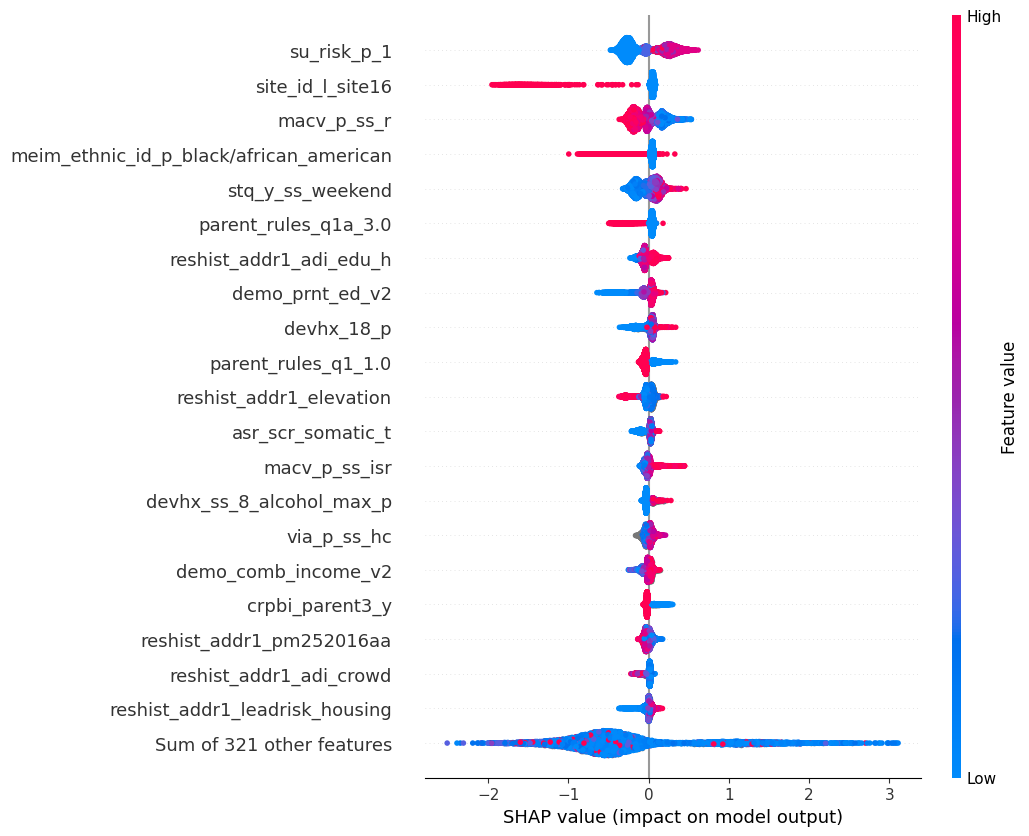

In [36]:
shap.plots.beeswarm(shap_values, max_display=21)

# SHAP dependence plots

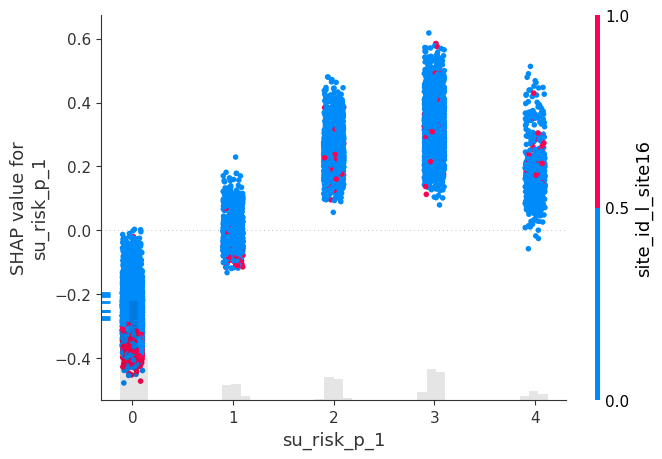

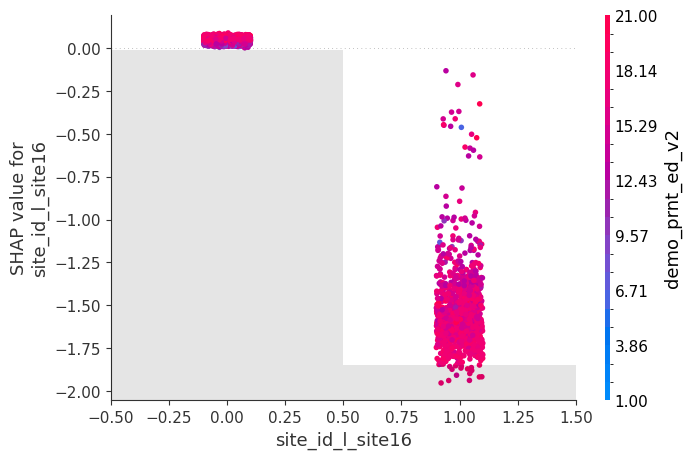

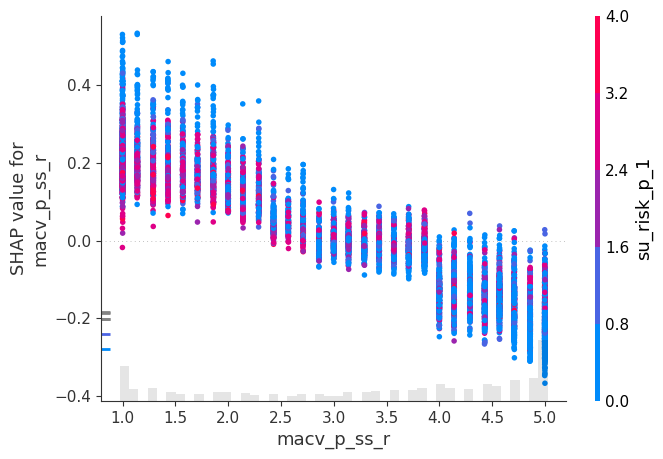

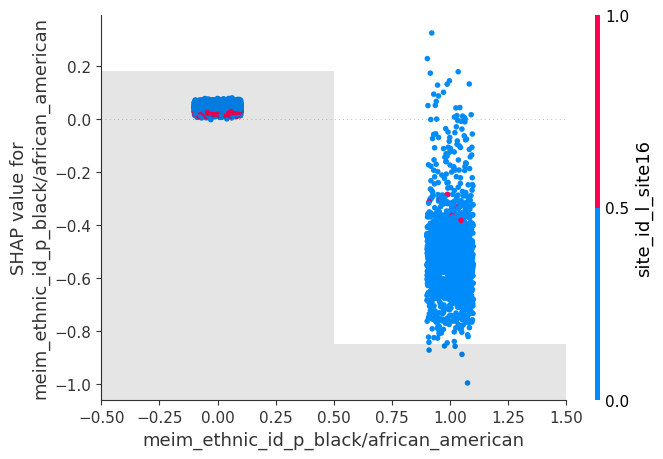

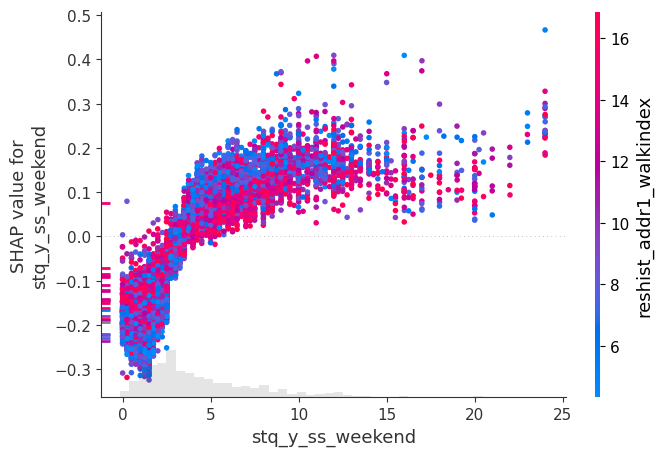

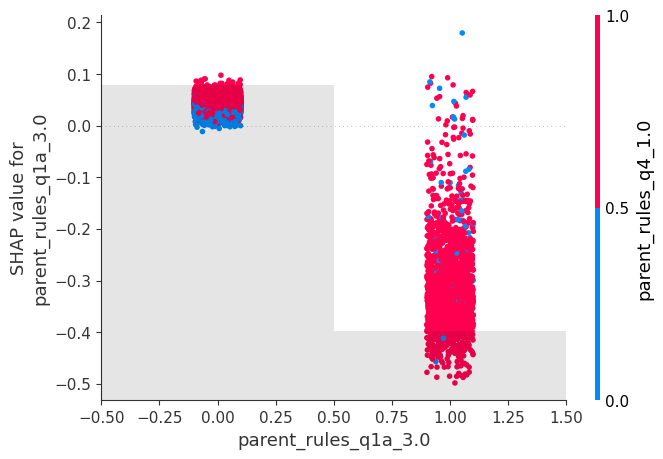

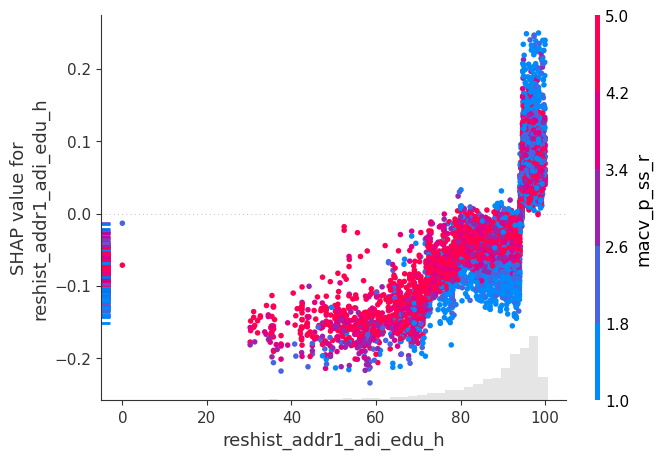

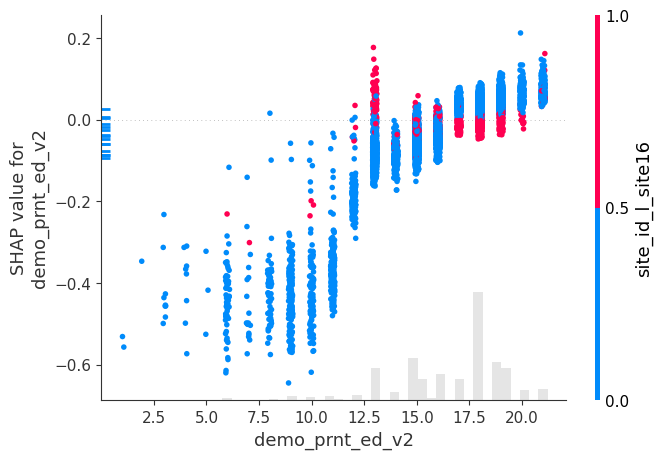

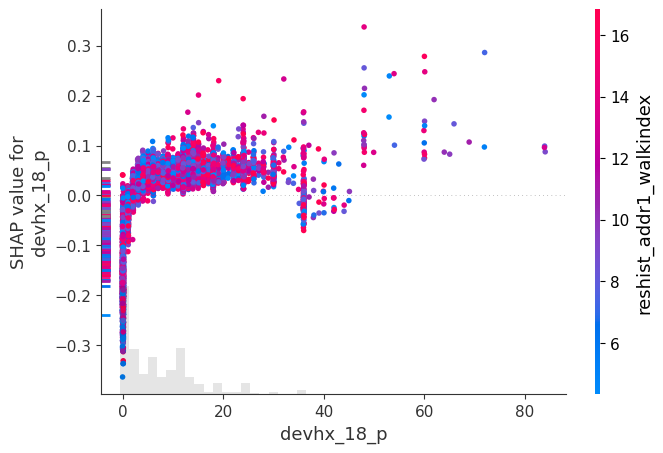

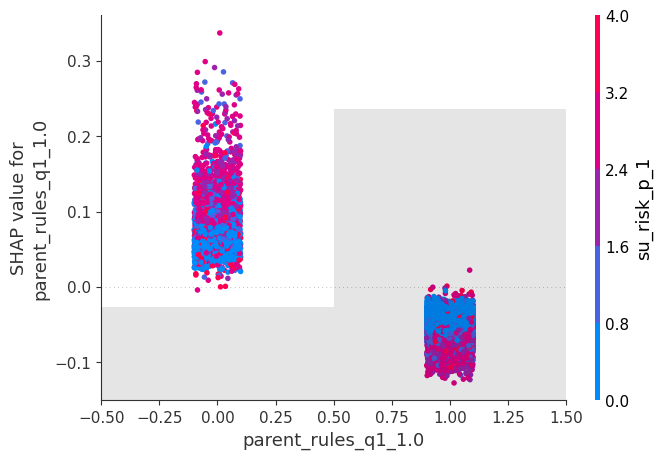

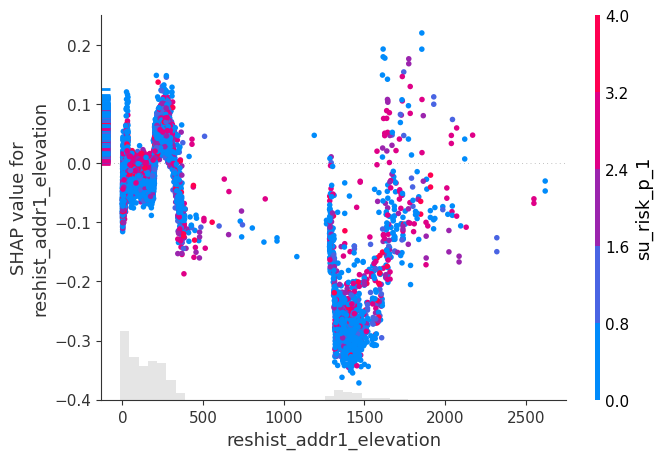

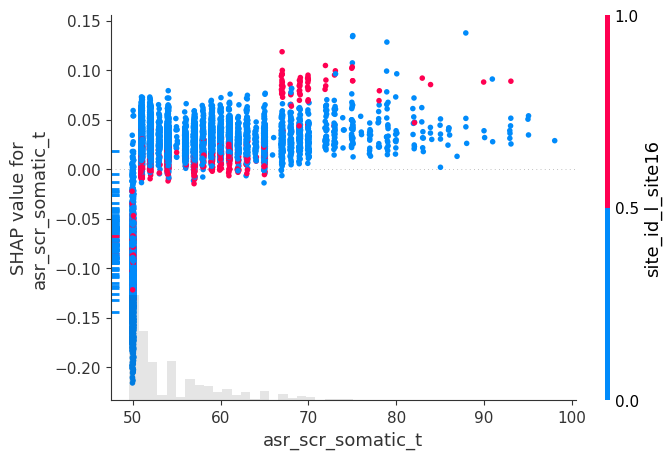

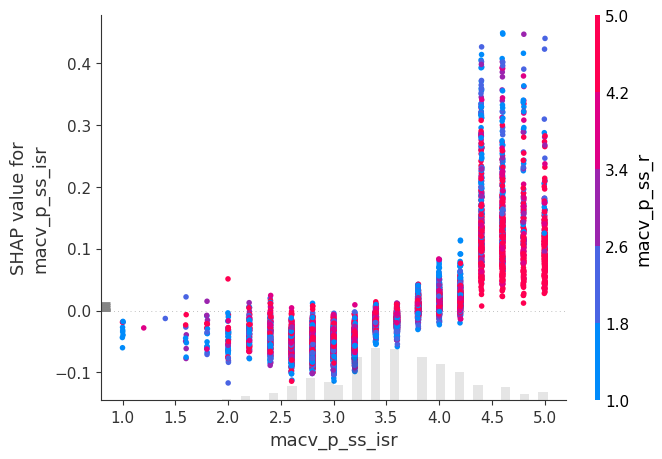

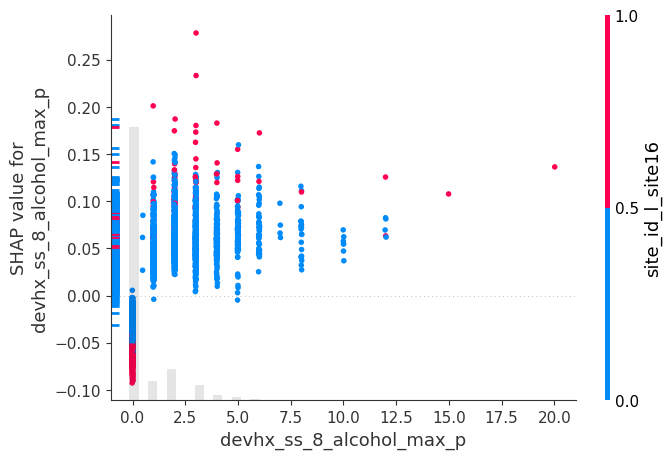

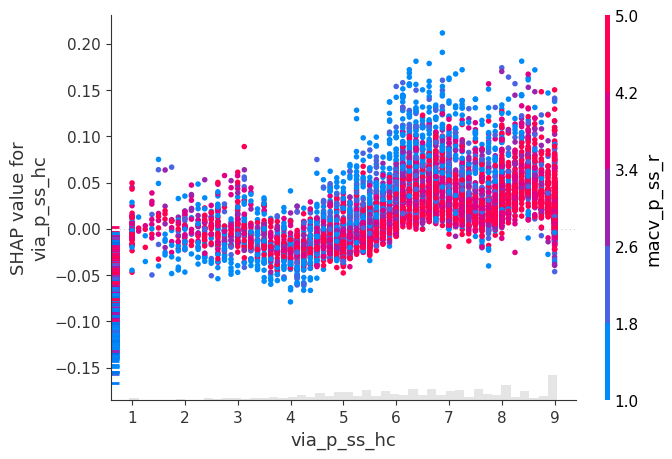

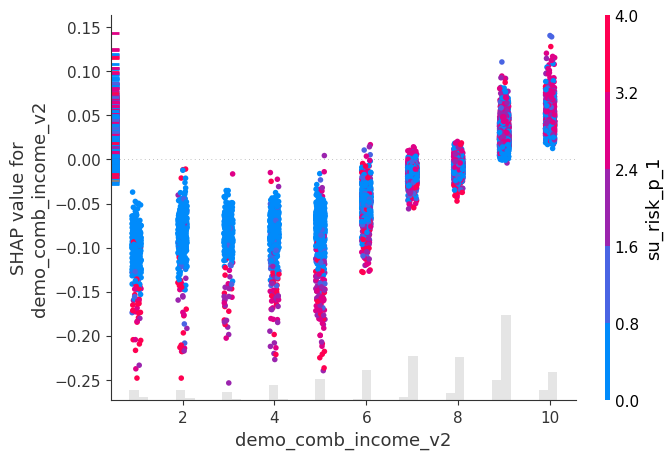

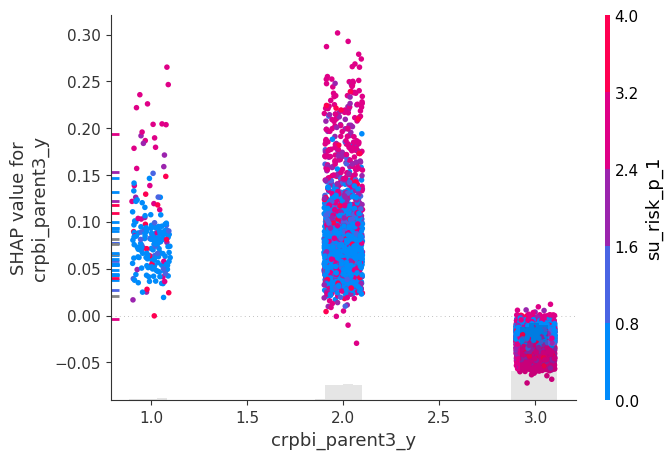

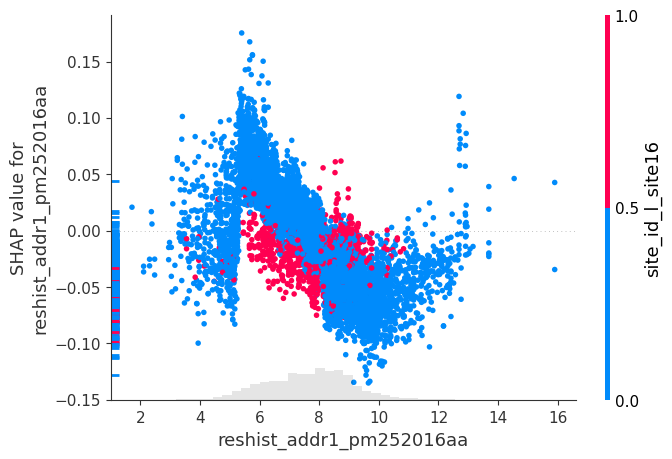

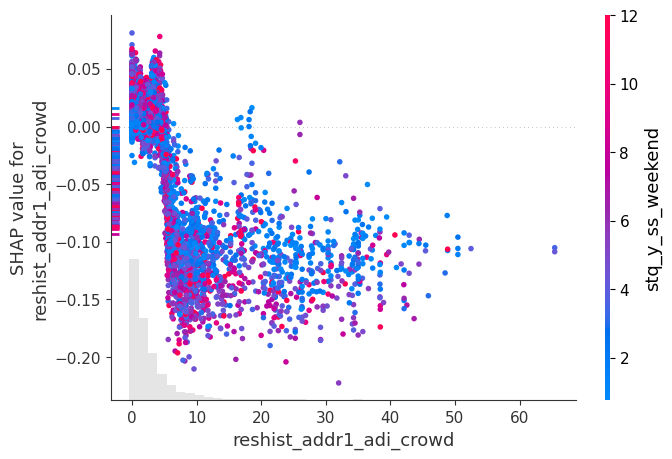

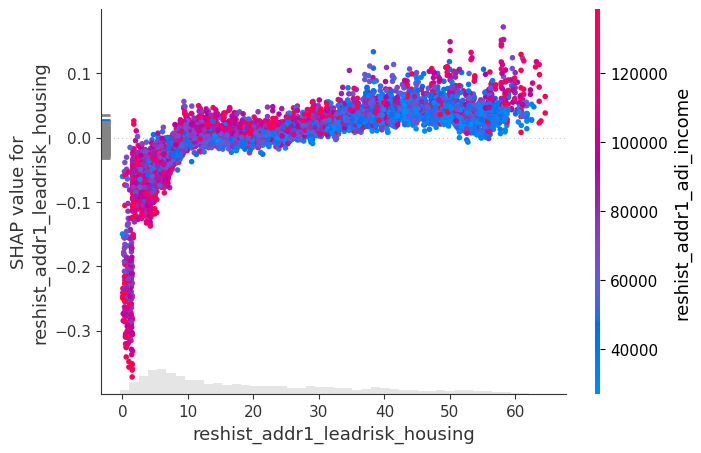

In [37]:
top_inds = np.argsort(-np.sum(np.abs(shap_values.values), 0))
for i in range(20):
    shap.plots.scatter(shap_values[:, top_inds[i]], color=shap_values)